<h1>Random Forest</h1>

##Import + Montaggio cartella Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install joblib

In [3]:
!pip install tqdm_joblib

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm_joblib import tqdm_joblib
from tqdm import tqdm
tqdm.pandas()
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Caricamento del dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Progetto_NLP/Dataset_label/trainWithFeaturesAndEmbeddings.csv')
df.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,Good Afternoon from a rather cool and damp Ess...,Books & Literature,Positive,44,['author'],1,3,0,0,-0.009258,...,-0.011806,-0.040050,-0.028320,-0.032246,0.013747,0.054467,0.060302,0.093453,-0.090176,0.011050
1,2) My favorite fictional spice is melange. My ...,General Activities,Neutral,16,[],0,2,1,0,-0.066764,...,-0.044040,-0.040336,-0.050697,0.083287,0.021824,-0.114995,0.034062,0.049423,-0.062629,-0.008898
2,Guess the German utensil! https://https://t.co...,Trivia & Fun Facts,Positive,9,[],0,0,0,0,-0.067560,...,0.006027,0.038677,0.040306,-0.042645,0.012359,0.042093,0.029526,-0.007695,-0.031263,0.125133
3,I am quite tempted to spend the entirety of th...,Fashion & Style,Negative,21,[],0,0,0,0,-0.060903,...,0.008680,0.094215,0.019267,-0.033533,-0.053666,-0.031781,-0.021230,-0.114671,-0.090589,0.035798
4,I heard different on cnn,Journalism,Neutral,5,[],0,0,0,0,0.040691,...,0.099750,0.041532,-0.033229,-0.098661,0.032493,-0.044346,-0.008297,-0.068045,0.078471,-0.020324


In [6]:
df_test = pd.read_csv('/content/drive/MyDrive/Progetto_NLP/Dataset_label/testWithFeaturesAndEmbeddings.csv')
df_test.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,thank you! 🥹❤️❤️,Fashion & Style,Positive,8,[],0,1,0,0,-0.025975,...,-0.019321,0.040424,-0.014585,0.038854,0.056717,0.119614,0.014514,0.120229,-0.027037,0.030239
1,The Next Chapter for NativeScript: nStudio by ...,Programming,Neutral,17,['javascript'],1,0,0,0,-0.068502,...,0.022137,-0.038811,-0.070492,-0.030029,-0.046116,0.002696,-0.022367,0.102057,0.002136,0.029075
2,lwj doesn't speak for longer than he would've ...,Social Media,Negative,63,[],0,1,0,0,-0.005183,...,-0.002973,0.010910,0.036041,0.007441,-0.064407,-0.065380,0.042773,0.007973,-0.001446,0.040114
3,"The truth is ""a liberal reassurance narrative?""",Journalism,Neutral,10,[],0,1,0,0,0.068206,...,0.040749,-0.037523,-0.047591,-0.059627,-0.055182,-0.004068,-0.040202,0.042814,0.081529,-0.051749
4,Such a great film.,Movies & TV,Positive,5,['film'],1,1,0,0,-0.059131,...,0.067459,0.010276,0.016515,-0.057109,-0.004752,0.025960,0.032027,-0.006660,0.000614,0.001283


In [7]:
df_val = pd.read_csv('/content/drive/MyDrive/Progetto_NLP/Dataset_label/validationWithFeaturesAndEmbeddings.csv')
df_val.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,Quick plug on this new platform for some of my...,Social Media,Neutral,52,[],0,1,2,0,-0.065827,...,-0.004585,-0.058114,0.033320,0.102114,-0.053937,0.087153,0.105939,-0.026751,-0.048552,0.044566
1,ok whatthefuck,Gaming,Neutral,2,[],0,0,0,0,0.001517,...,0.112817,-0.007861,0.016383,0.031305,-0.021063,0.024053,-0.002595,0.020050,0.092061,-0.033776
2,Paketocas https://twitter.com/324cat/status/16...,Social Media,Neutral,2,[],0,0,0,0,-0.062472,...,0.017665,0.009573,-0.017845,-0.084442,0.014240,-0.030893,0.067415,0.004409,0.036922,-0.007215
3,All that dreaming 😴 of food has exhausted her ...,General Activities,Positive,17,[],0,0,1,0,0.047092,...,0.013538,-0.036066,0.028027,-0.020379,-0.030251,0.096698,0.068467,0.015141,-0.089595,0.007898
4,this is def the Mental Illness™ talking but i ...,Mental Health,Neutral,20,[],0,2,1,0,-0.024350,...,0.058399,0.049774,0.031252,0.007518,-0.061681,0.016520,0.101300,0.105141,0.010822,-0.024825


##Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854596 entries, 0 to 854595
Columns: 393 entries, text to embed_383
dtypes: float64(384), int64(5), object(4)
memory usage: 2.5+ GB


In [9]:
df.keys()

Index(['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount',
       'positiveCount', 'negativeCount', 'hasNo', 'embed_0',
       ...
       'embed_374', 'embed_375', 'embed_376', 'embed_377', 'embed_378',
       'embed_379', 'embed_380', 'embed_381', 'embed_382', 'embed_383'],
      dtype='object', length=393)

In [10]:
df = df.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 854577 entries, 0 to 854595
Columns: 393 entries, text to embed_383
dtypes: float64(384), int64(5), object(4)
memory usage: 2.5+ GB


In [11]:
df_val = df_val.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])
df_test = df_test.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])

In [12]:
STOPWORDS_EN    = set(stopwords.words('english'))
NEGATION_WORDS = {"n't", "not", "no", "never"}
PUNCTUATION    = set(string.punctuation)
LEMMATIZER     = WordNetLemmatizer()

In [13]:
def normalize_text(text, lemmatizer, lemmatizer_func="lemmatize"):
  text = text.lower()
  tokens = word_tokenize(text)
  lemmatize = getattr(lemmatizer, lemmatizer_func)
  normalized = []

  prefix_NOT = False
  for token in tokens:
    if token in NEGATION_WORDS:
      prefix_NOT = True
      normalized.append(token)
      continue

    if token in PUNCTUATION:
      prefix_NOT = False
      normalized.append(token)
      continue

    if token in STOPWORDS_EN:
      continue

    token = lemmatize(token)
    if prefix_NOT:
      token = f"NOT_{token}"
    normalized.append(token)

  return normalized

In [14]:
df['text_tokens'] = df['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))

df = df[df['text_tokens'].apply(lambda tokens: len(tokens) > 0)].copy()
df.reset_index(drop=True, inplace=True)

100%|██████████| 854577/854577 [03:09<00:00, 4510.08it/s]


In [15]:
df_val['text_tokens'] = df_val['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))
df_test['text_tokens']= df_test['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))

100%|██████████| 183123/183123 [00:40<00:00, 4472.29it/s]


In [16]:
numeric_features = ['length', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'] \
                 + [f'embed_{i}' for i in range(384)]
numeric_transformer = StandardScaler()

categorical_features = ['topic']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_features = 'text_tokens'
text_transformer = CountVectorizer(
  analyzer=lambda tokens: tokens,
  lowercase=False,
  token_pattern=None
)

preprocessor = ColumnTransformer(
  transformers=[
      ('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features),
      ('txt', text_transformer, text_features),
  ],
  remainder='drop'
)

##Train/Validation/Test split



In [17]:
from sklearn.model_selection import train_test_split

def sample_balanced_df(df, label_col, sample_size, random_state=42):
    """
    Campiona un sottoinsieme stratificato da qualsiasi DataFrame (train, val o test).

    Args:
        df (pd.DataFrame): Il dataset di input (train, val o test).
        label_col (str): Colonna target su cui fare stratificazione.
        sample_size (int): Numero di istanze desiderate.
        random_state (int): Seed per riproducibilità.

    Returns:
        pd.DataFrame: Campione stratificato del DataFrame.
    """
    if sample_size >= len(df):
        print(f"Sample size ({sample_size}) >= dataset size ({len(df)}). Nessun campionamento.")
        return df.copy()

    df_sampled, _ = train_test_split(
        df,
        train_size=sample_size,
        stratify=df[label_col],
        random_state=random_state
    )
    return df_sampled


In [18]:
df_train = sample_balanced_df(df, label_col='sentiment', sample_size=500000)

In [19]:
df_val   = sample_balanced_df(df_val, label_col='sentiment', sample_size=10000)
df_test  = sample_balanced_df(df_test, label_col='sentiment', sample_size=10000)

In [20]:
X_train = df_train.drop(columns="sentiment")
y_train = df_train["sentiment"]

X_val = df_val.drop(columns="sentiment")
y_val = df_val["sentiment"]

X_test = df_test.drop(columns="sentiment")
y_test = df_test["sentiment"]

print(f"Shape X_train: {X_train.shape}, Shape X_val: {X_val.shape}, Shape X_test: {X_test.shape}")

Shape X_train: (500000, 393), Shape X_val: (10000, 393), Shape X_test: (10000, 393)


In [21]:
for X in [X_train, X_val, X_test]:
    X.drop(columns=['text'], inplace=True)

# One-Hot Encoding per la colonna 'topic'
X_train = pd.get_dummies(X_train, columns=['topic'])
X_val   = pd.get_dummies(X_val, columns=['topic'])
X_test  = pd.get_dummies(X_test, columns=['topic'])

X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [22]:
X_train.drop(columns=['topicWords'], inplace=True)
X_val.drop(columns=['topicWords'], inplace=True)
X_test.drop(columns=['topicWords'], inplace=True)

In [23]:
for col in X_train.columns:
    if X_train[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
        print(f"Colonna con liste: {col}")

Colonna con liste: text_tokens


In [24]:
X_train['text_tokens_len'] = X_train['text_tokens'].apply(len)
X_val['text_tokens_len'] = X_val['text_tokens'].apply(len)
X_test['text_tokens_len'] = X_test['text_tokens'].apply(len)

X_train = X_train.drop(columns=['text_tokens'])
X_val = X_val.drop(columns=['text_tokens'])
X_test = X_test.drop(columns=['text_tokens'])

## Definizione e addestramento Random Forest

In [25]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

print("Training con cross-validation...")

for train_index, val_index in tqdm(skf.split(X_train, y_train), total=skf.get_n_splits()):
    X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_cv_train, y_cv_train)
    y_pred = model.predict(X_cv_val)

    accuracies.append(accuracy_score(y_cv_val, y_pred))
    precisions.append(precision_score(y_cv_val, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_cv_val, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_cv_val, y_pred, average='weighted'))

print("\nCross-validation conclusa.")
print(f"Accuracy media:  {np.mean(accuracies):.4f}")
print(f"Precision media: {np.mean(precisions):.4f}")
print(f"Recall media:    {np.mean(recalls):.4f}")
print(f"F1-score media:  {np.mean(f1_scores):.4f}")

Training con cross-validation...


100%|██████████| 10/10 [5:02:50<00:00, 1817.10s/it]


Cross-validation conclusa.
Accuracy media:  0.6014
Precision media: 0.6050
Recall media:    0.6014
F1-score media:  0.5965



🎯 Risultati sul validation set:
Accuracy:  0.6028
Precision: 0.6055
Recall:    0.6028
F1 Score:  0.5974


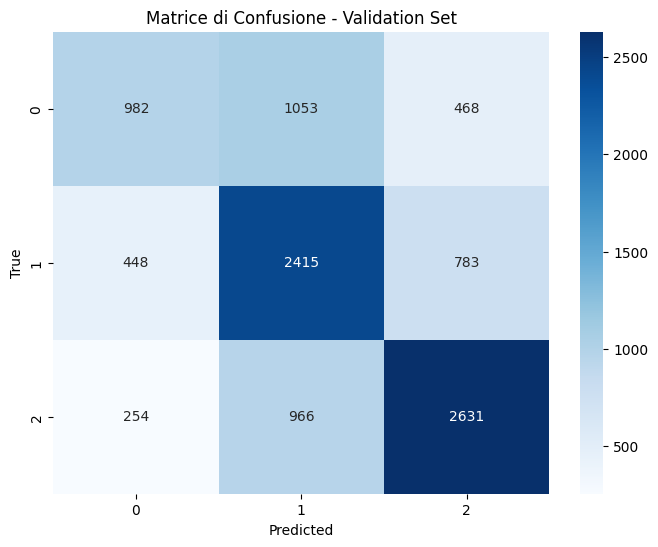

In [26]:
# Valutazione sul validation set
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)
val_preds = final_model.predict(X_val)

print("\n🎯 Risultati sul validation set:")
print(f"Accuracy:  {accuracy_score(y_val, val_preds):.4f}")
print(f"Precision: {precision_score(y_val, val_preds, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_val, val_preds, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_val, val_preds, average='weighted'):.4f}")

cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


📊 Risultati sul test set:
Accuracy:  0.6041
Precision: 0.6073
Recall:    0.6041
F1 Score:  0.5995


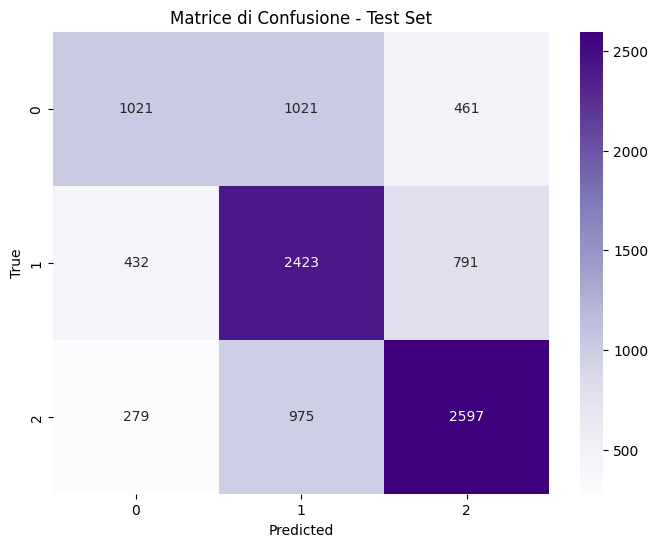

In [27]:
# Valutazione finale sul test set
test_preds = final_model.predict(X_test)

print("\n📊 Risultati sul test set:")
print(f"Accuracy:  {accuracy_score(y_test, test_preds):.4f}")
print(f"Precision: {precision_score(y_test, test_preds, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, test_preds, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test, test_preds, average='weighted'):.4f}")

cm_test = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples')
plt.title('Matrice di Confusione - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Salvataggio modello

In [28]:
model_path = '/content/drive/MyDrive/Progetto_NLP/modelli/final_model_RandomForest.joblib'
joblib.dump(final_model, model_path)

print(f"Modello salvato in: {model_path}")

Modello salvato in: /content/drive/MyDrive/Progetto_NLP/modelli/final_model_RandomForest.joblib
